In [1]:
import numpy as np
import pandas as pd
import logging
import os
from scipy import interpolate

In [2]:
def preProcess(cwd):
    fileNames = os.listdir(cwd)
    clearedData = pd.ExcelWriter('clearedData.xlsx')
    for f in fileNames:
        if os.path.splitext(f)[1] == '.xlsx':
            ff = os.path.join('data', f)
            df = pd.read_excel(ff, 'Sheet1')
            time = df.loc[:,'TIME'].values[1:]
            time1 = df.loc[:, 'TIME.1'].values[1:]
            
            time = np.array(time)[~np.isnan(time)]
            time1 = np.array(time1)[~np.isnan(time1)]
            
            (timeEps, timeLP) = (time, time1) if len(time) < len(time1) else (time1, time)
            eps = df.loc[:, 'EPS'].values[1:]
            eps = np.array(eps)[~np.isnan(eps)]
            
            #timeLP = np.array(timeLP)[np.where(timeLP < np.max(timeEps))]
            #wprint(timeLP)
            timeLP = timeLP[timeLP < np.max(timeEps)]
            funcInterp = interpolate.interp1d(timeEps, eps, bounds_error=None)
            epsFullLength = funcInterp(timeLP).reshape(-1,1)
            timeLP = timeLP.reshape(-1,1)
            LP = df.loc[:,'LP'].values[1:]
            LP = LP[0:len(timeLP)].reshape(-1,1)
            
            TRI = df.loc[:,'TRI'].values[1:]
            TRI = TRI[0:len(timeLP)].reshape(-1, 1)

            data = np.hstack([timeLP, epsFullLength, LP, TRI])
            dff = pd.DataFrame(data, columns=['TIME', 'EPS', 'LP', 'TRI'])
            dff.to_excel(clearedData, sheet_name=os.path.splitext(f)[0])
    clearedData.save()

In [3]:
def readXlsx(fileName):
    """
    read all sheets in xls file
    input:
        fileName
    output:
        listEta, listThetaBar, listEpsilon in sheets
    """
    xlsx = pd.ExcelFile(fileName)
    etaThetaEpsilon = []
    for sheet in xlsx.sheet_names:
        #print(sheet)
        df = pd.read_excel(xlsx, sheet)
        eta = df.loc[:, 'TRI'].values.reshape(-1, 1)
        thetaBar = df.loc[:, 'LP'].values.reshape(-1, 1)
        eplison = df.loc[:, 'EPS'].values.reshape(-1, 1)
        ind = np.where(eplison>0)
        #print(sheet)
        #print(ind)
        ete = np.hstack([eta, thetaBar, eplison])
        
        etaThetaEpsilon.append(ete[ind[0],:])
    
    #logging.debug(etaThetaEpsilon)
    etaThetaEpsilon = np.array(etaThetaEpsilon)
    return etaThetaEpsilon

In [4]:
tests = readXlsx('clearedData.xlsx')


In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()

ax = fig.gca(projection='3d')
for test in tests:
    xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
    ax.plot(xx, yy, zz)#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.xaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('Triaxiality')
    ax.set_ylabel('Lode Parameter')
    ax.set_zlabel('Failure plastic strain')

plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
from scipy import integrate

def simplifiedMMC(eta, thetaBar, param):
    """
    simplified MMC model 
    sigma = A * eps_p^n
    output:
        epsilonPlasticFailure: failure strain
    """
    A, n, c1, c2 = param
    #print(param)
    comp1 = np.sqrt((1+np.power(c1, 2)) / 3) * np.cos(thetaBar * np.pi / 6)
    #print(comp1.shape)
    comp2 = c1 * (eta + 1 / 3 * np.sin(thetaBar * np.pi / 6))
    #print(A / c2 * (comp1 + comp2), -1/n)
    comp = comp1 + comp2
    #comp = comp[np.where(comp>0)]
    epsilonPlasticFailure = np.power(A / c2 * comp, -1/n)
    #print(epsilonPlasticFailure.shape)
    #print(np.any(np.isnan(epsilonPlasticFailure)))
    return epsilonPlasticFailure

def accumulatedDamage(model, eta, thetaBar, epsilon, param):
    """
    Accumulating Damage Model
    input:
        model: Damage mode
        eta: eta list
        thetaBar: theraBar list
        epsilon: epsilon List
        param: A, n, c1, c2
    output:
        damage Indicator
    """
    #'epsilonMMC = np.zeros(eta.shape)'
    #'for ii, (eta, thetaBar) in  enumerate(zip(eta, thetaBar)):'
    epsilonPlasticFailure = model(eta, thetaBar, param)
    #'epsilonMMC[ii] = epsilonPlaticFailure'
   
    damageIndicator = integrate.trapz(1/ epsilonPlasticFailure, epsilon)
                      #np.sum(epsilon / epsilonPlasticFailure)
                      #integrate.tr (1 / epsilonPlaticFailure, epsilon)

    #print(epsilonPlasticFailure)
    return damageIndicator

def MMCSurface(*param):
    eta = np.arange(0, 1.1, 0.1)
    theta = np.arange(-1, 1.1, 0.1)
    etaX, thetaY = np.meshgrid(eta, theta, sparse=False)
    #z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
    #h = plt.contourf(x,y,z)
    epsilon = simplifiedMMC(etaX, thetaY, param)
    return etaX, thetaY, epsilon

In [7]:
from scipy import optimize

def testResultsAcc(param, tests):
    """
    tests result to damgaIndicator
    """
    indicators = np.zeros([tests.shape[0]])
    for ii, test in enumerate(tests):
        eta = test[:, 0]
        theta = test[:, 1]
        epsilon = test[:, 2]
        damageIndicator = accumulatedDamage(simplifiedMMC, eta, theta, epsilon, param)
        #print(damageIndicator)
        indicators[ii] = damageIndicator
    return indicators

def testResulsUsingFractureStrain(param, tests):
    epsMMC = np.array([simplifiedMMC(test[-1,0], test[-1, 1], param) for test in tests]).reshape(-1,1)
    #epsTest = tests[:, -1, 2].reshape(-1,1)
    return epsMMC 


    

def errAcc(param, x, y):
    A, n, c1, c2 = param
    #print(Paramters.A, Paramters.n)
    return testResultsAcc((A,n, c1, c2), x) - y

def errFractureStrain(param, x, y):
    epsMMC = testResulsUsingFractureStrain(param, x)
    epsTest = np.array([test[-1, 2] for test in x]).reshape(-1,1)
    #print((epsMMC-epsTest).T)
    return (epsMMC - epsTest).T[0]

def fitModelUsingFractureStrain(tests):
    targets = np.ones([tests.shape[0]])
    #result = testResults(tests,(996.68, 0.026, 0.1, 500))
    res = optimize.least_squares(errFractureStrain, (500, 0.1, .1, 600), args=(tests, targets))
    
    #print(err(res[0], tests, targets))
    #indicators = testResults(tests, (96.68, 0.02772, res[0][0], res[0][1]))
    #Aprint(func((996.68, 0.02772,res[0][0], res[0][1]), tests))
    return res

def fitDamageAcc(tests, res0):
    targets = np.ones([tests.shape[0]])
    #result = testResults(tests,(996.68, 0.026, 0.1, 500))
    res = optimize.least_squares(errAcc, res0, args=(tests, targets))
    
    #print(err(res[0], tests, targets))
    #indicators = testResults(tests, (96.68, 0.02772, res[0][0], res[0][1]))
    #Aprint(func((996.68, 0.02772,res[0][0], res[0][1]), tests))
    return res


In [8]:
resUsingFractureStrain = fitModelUsingFractureStrain(tests)
resUsingFractureStrain

 active_mask: array([0., 0., 0., 0.])
        cost: 0.1986056152981445
         fun: array([-0.02767954, -0.32375545, -0.00688036,  0.09007201,  0.05234063,
        0.12802299,  0.23547334,  0.11579537, -0.21785476, -0.32369199,
        0.09324662,  0.18561863,  0.00962234, -0.00157707])
        grad: array([-4.73493411e-09,  8.94322087e-05, -1.07628634e-04,  8.00117187e-09])
         jac: array([[-4.76149410e-05,  1.08591669e+00, -1.26881605e+00,
         8.04726731e-05],
       [-5.43207472e-05,  1.09205592e+00, -1.36528309e+00,
         9.18059692e-05],
       [-6.76065655e-05,  1.05576521e+00, -1.52332485e+00,
         1.14259955e-04],
       [-7.37466573e-05,  1.02016539e+00, -1.54112598e+00,
         1.24637150e-04],
       [-4.92386475e-05,  1.08908384e+00, -1.29661675e+00,
         8.32168533e-05],
       [-5.66000435e-05,  1.09016316e+00, -1.16145371e+00,
         9.56581418e-05],
       [-5.84955906e-05,  1.08715168e+00, -1.39854849e+00,
         9.88617512e-05],
       [-6.1

In [9]:
resAcc = fitDamageAcc(tests, resUsingFractureStrain.x)
resAcc

/Users/aaron/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


 active_mask: array([0., 0., 0., 0.])
        cost: 0.8419699169136329
         fun: array([ 0.21312491,  0.38122045, -0.16909426, -0.44708573, -0.15970225,
       -0.31921267, -0.59828414, -0.45867066,  0.43341327,  0.32839342,
       -0.07925993, -0.44837958, -0.15736916, -0.2029904 ])
        grad: array([ 1.73712116e-08, -2.89718508e-04,  3.88871520e-04, -2.71723552e-08])
         jac: array([[ 4.88814298e-04, -1.16995282e+01,  1.33806721e+01,
        -7.64661931e-04],
       [ 5.56546403e-04, -7.90027200e+00,  1.33305954e+01,
        -8.70616609e-04],
       [ 3.34803614e-04, -3.66321408e+00,  7.33919529e+00,
        -5.23739955e-04],
       [ 2.22790251e-04, -1.20557375e+00,  4.49830531e+00,
        -3.48515221e-04],
       [ 3.38588015e-04, -7.12325755e+00,  8.96344220e+00,
        -5.29659967e-04],
       [ 2.74315183e-04, -5.11930253e+00,  5.38913381e+00,
        -4.29116698e-04],
       [ 1.61866642e-04, -2.74373094e+00,  3.86291210e+00,
        -2.53211209e-04],
       [ 2.1

In [10]:
def planeStressMMC(model, param):
    points = []
    for sigma1 in np.range(0, 1.1, 0.1):
        sigma2 = 0
        while True:
            pressure = (sigma2 + sigma1) / 3
            mises = np.sqrt(((sigma1-sigma2) ** 2 + sigma2 ** 2 + sigma1 ** 2)/2)
            tri = pressure / mises
            lp = (2 * sigma2 - sigma1) / sigma1
            points.append(tri, lp)
            sigma2 = sigma2 + 0.1
            if(sigma2 > sigma1):
                break
    triLp = np.array(points)
    strain = model(triLp[:, 0], triLp[:, 1], param)
    
    return np.hstack([triLp, strain]).reshape(-1,1) 
line = planeStressMMC(simplifiedMMC, resAcc)

def showFigure(faiureSurface, tests):
    XX, YY, zz = faiureSurface
    fig = plt.figure()
    #plt.xlabel('Triaxiality')
    #plt.ylabel('Lode Parameter')
    #plt.zlabel('Failure plastic strain')
    ax = fig.gca(projection='3d')
    #cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    #cbar = fig.colorbar(cs)
    ax.scatter3D(XX, YY, zz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    for test in tests:
        xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
        ax.plot(xx, yy, zz)#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    global line
    ax.plot(line[:, 0], )
    ax.xaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('Triaxiality')
    ax.set_ylabel('Lode Parameter')
    ax.set_zlabel('Failure plastic strain')
    ax.set_zbound([0,1.5])
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f')
    plt.show()

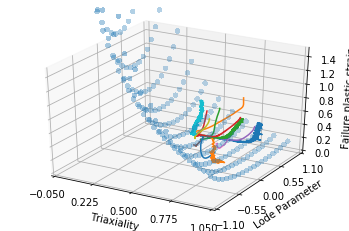

In [423]:
a, b , c, d = resAcc.x[:]
failureSurface = MMCSurface(a, b, c,d)
showFigure(failureSurface, tests)

SyntaxError: invalid character in identifier (<ipython-input-11-92a86db762a9>, line 6)